In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
from simulator import get_simulator
from simulate import simulate
from simulate import mpi_simulate
from meanfield import meanfield

# Defining The System 

In [3]:
system = {
    'duration': 1, 
    'resolution': 0.001,
    'species': [
        ('P', 0), 
        ('N', 10000), 
    ],
    'reactions': [
        (
            'omega', 
            ((1, 'N'), ),
            ((2, 'N'), )
        ), 
        (
            'alpha', 
            ((1, 'N'), ),
            ((1, 'P'), )
        ), 
        (
            'beta', 
            ((1, 'P'), ),
            ((1, 'N'), )
        ), 
        (
            'mu_P', 
            ((1, 'P'), ), 
            ()
        ), 
        (
            'mu_N', 
            ((1, 'N'), ), 
            ()
        ), 
    ], 
    'variables': [
        ('omega', 1.0), 
        ('alpha', 1.0), 
        ('beta', 1.0), 
        ('mu_P', 1.0), 
        ('mu_N', 1.0), 
    ], 
    'functions': [], 
    'targets': [
        'time', 
        'P', 
        'N', 
    ],
}

# Running Single Trajectories 

In [4]:
run = get_simulator(system)

Compiling ./gillespie_2.pyx because it changed.
[1/1] Cythonizing ./gillespie_2.pyx
running clean
removing 'build/temp.linux-x86_64-3.7' (and everything under it)
removing 'build'
running build_ext
building 'gillespie_2' extension
creating build/temp.linux-x86_64-3.7
gcc -pthread -B /home/cogle/dev/anaconda3/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/cogle/dev/anaconda3/lib/python3.7/site-packages/numpy/core/include -I/home/cogle/dev/anaconda3/include/python3.7m -c ./gillespie_2.c -o build/temp.linux-x86_64-3.7/./gillespie_2.o
gcc -pthread -shared -B /home/cogle/dev/anaconda3/compiler_compat -L/home/cogle/dev/anaconda3/lib -Wl,-rpath=/home/cogle/dev/anaconda3/lib -Wl,--no-as-needed -Wl,--sysroot=/ build/temp.linux-x86_64-3.7/./gillespie_2.o -o /home/cogle/dev/gillespie_modular/.simulators/gillespie_2.cpython-37m-x86_64-linux-gnu.so


### "0" is the random seed - it should never be repeated among trajectories for which a statistic is computed

In [5]:
data = run(0, mu_P=0.1)

In [6]:
system['targets'], data.shape

(['time', 'P', 'N'], (3, 1001))

### "data" is a 3 x 1001 array; the first index corresponds to a target (e.g. "time", "P", or "N"); the second index corresponds to a point in time (e.g. {0.000, 0.001, 0.002, ..., 0.999, 1.000} as specified in "system")

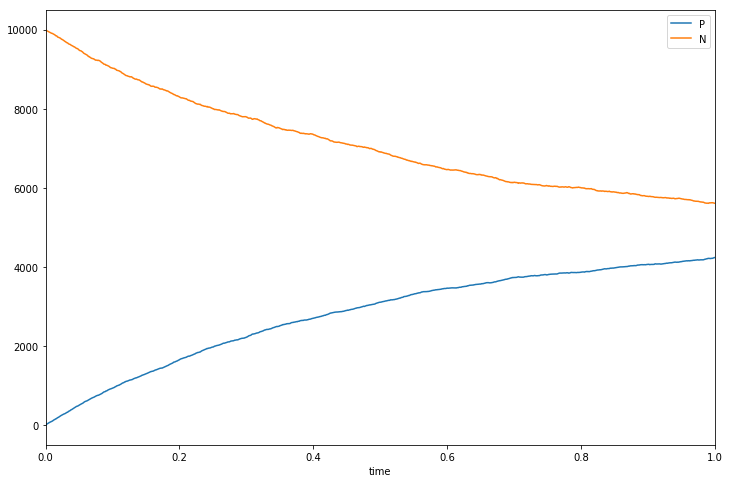

In [7]:
df = pd.DataFrame(OrderedDict((t, d) for t, d in zip(system['targets'], data)))
df.plot(x='time', kind='line', figsize=(12, 8))

# Computing Statistics Over Parameter Scans

    NOTE: "n_cores" should match the available physical cores (i.e. the number of bars visible when using
    "htop" in a terminal); use "htop" to monitor load on the hardware - all cores should be busy all the
    time while simulating to maximize performance.

In [8]:
axes = (
    ('mu_P', (1.0, 0.1, 0.01, 0.001)),
    ('mu_N', (1.0, 0.1, 0.01, 0.001)),
)
batchsize = 1000
processing = [(meanfield, ('time', 'P', 'N'))]
n_cores = 4

pspace, pscans = simulate(system, processing=processing, batchsize=batchsize, axes=axes, n_workers=n_cores)

100%|██████████| 16/16 [00:43<00:00,  1.97s/it]


### "pspace" is a pandas.DataFrame describing the trajectory through parameter space

### "pscans" is a list 1-1 with our processing, which contained 1 function; each entry (1) is a DataFrame which is 1-1 with the "pspace" DataFrame (16 locations, given 4 values for 2 axes as specified); each DataFrame has two columns: the labels and output data for the processing function for each point in the trajectory; the data is again a 3 x 1001 time series array which can be plotted

In [9]:
pspace

,mu_P,mu_N
0,1.000,1.000
1,1.000,0.100
2,1.000,0.010
3,1.000,0.001
4,0.100,1.000
5,0.100,0.100
6,0.100,0.010
7,0.100,0.001
8,0.010,1.000
9,0.010,0.100


In [10]:
pscans

[                              0  \
 0   [Mean time, Mean P, Mean N]   
 1   [Mean time, Mean P, Mean N]   
 2   [Mean time, Mean P, Mean N]   
 3   [Mean time, Mean P, Mean N]   
 4   [Mean time, Mean P, Mean N]   
 5   [Mean time, Mean P, Mean N]   
 6   [Mean time, Mean P, Mean N]   
 7   [Mean time, Mean P, Mean N]   
 8   [Mean time, Mean P, Mean N]   
 9   [Mean time, Mean P, Mean N]   
 10  [Mean time, Mean P, Mean N]   
 11  [Mean time, Mean P, Mean N]   
 12  [Mean time, Mean P, Mean N]   
 13  [Mean time, Mean P, Mean N]   
 14  [Mean time, Mean P, Mean N]   
 15  [Mean time, Mean P, Mean N]   
 
                                                     1  
 0   [[0.0, 0.0010000000000000007, 0.00200000000000...  
 1   [[0.0, 0.0010000000000000007, 0.00200000000000...  
 2   [[0.0, 0.0010000000000000007, 0.00200000000000...  
 3   [[0.0, 0.0010000000000000007, 0.00200000000000...  
 4   [[0.0, 0.0010000000000000007, 0.00200000000000...  
 5   [[0.0, 0.0010000000000000007, 0.0020000

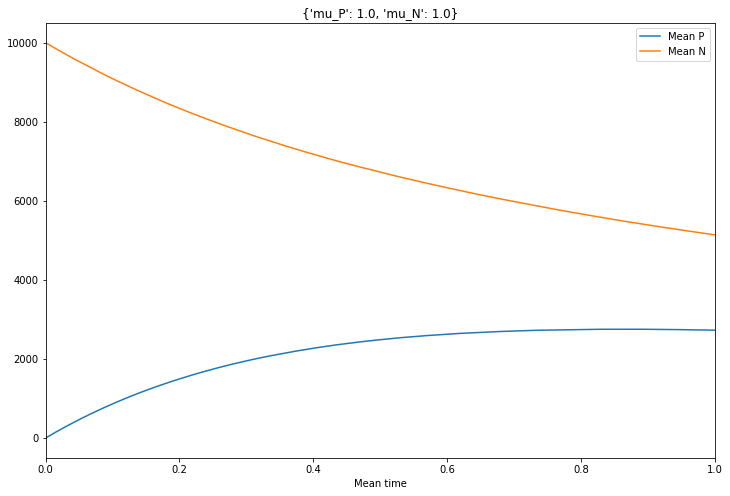

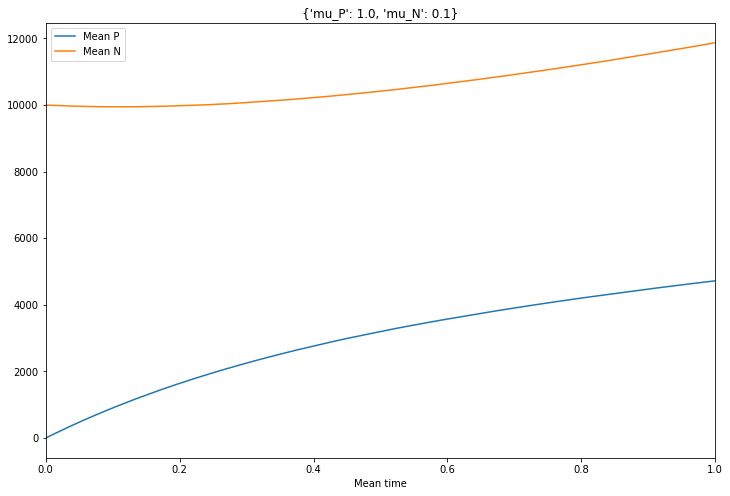

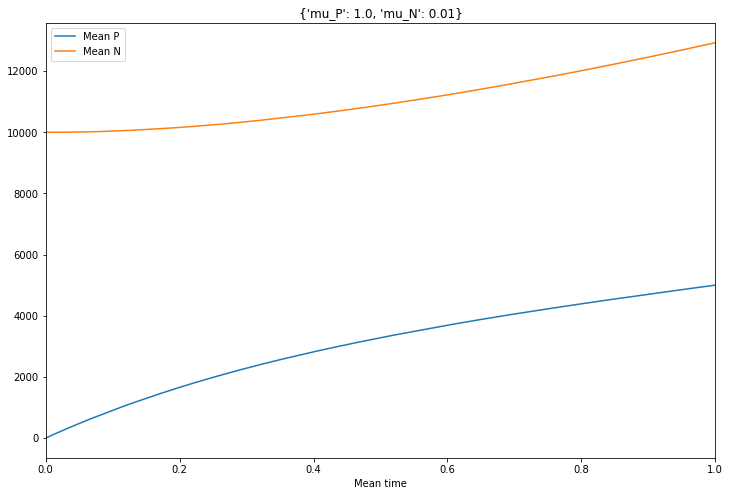

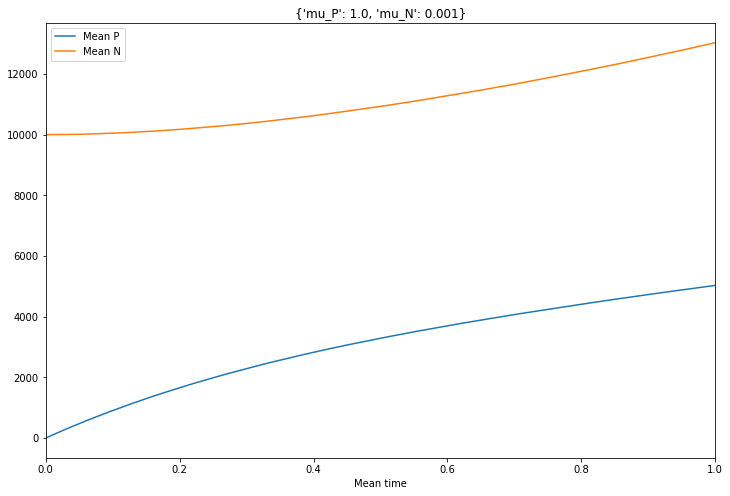

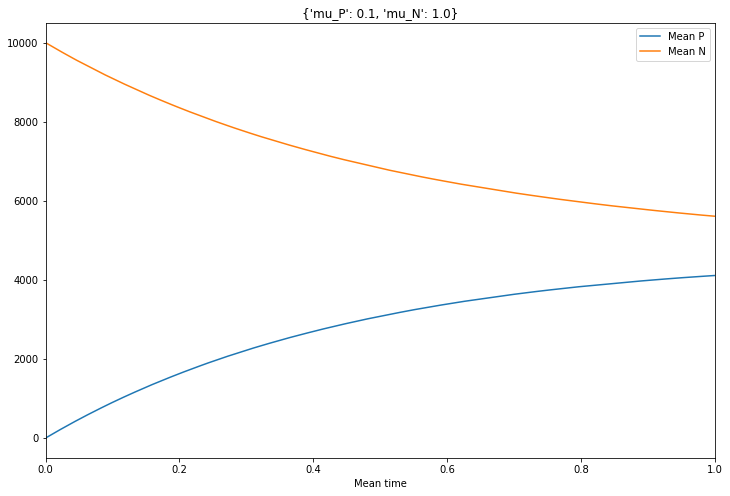

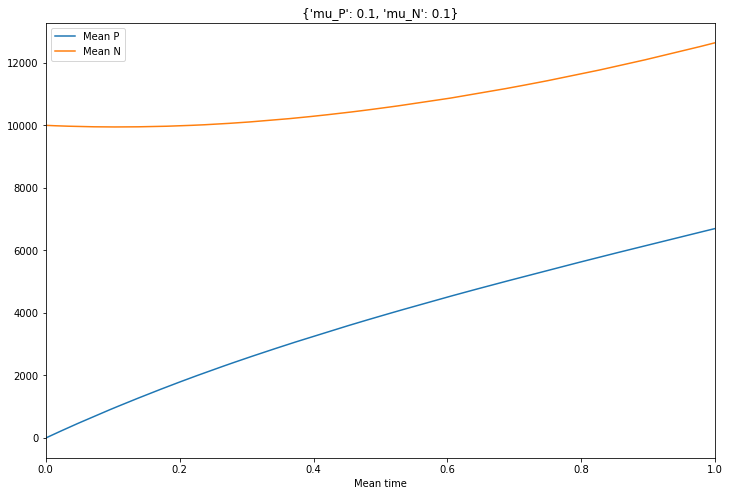

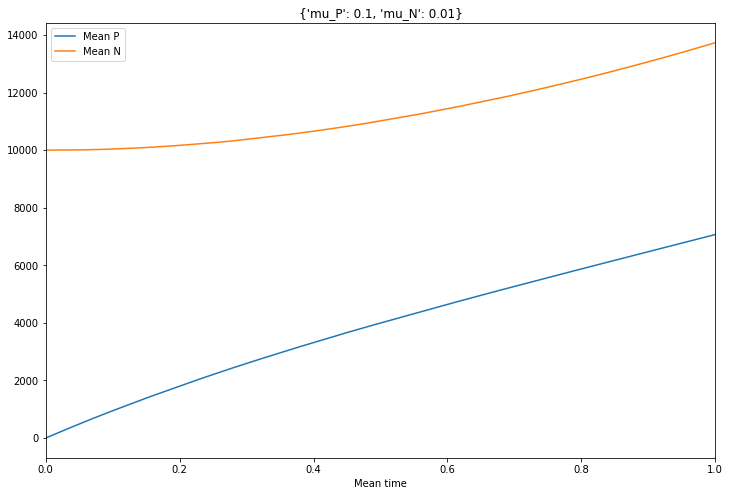

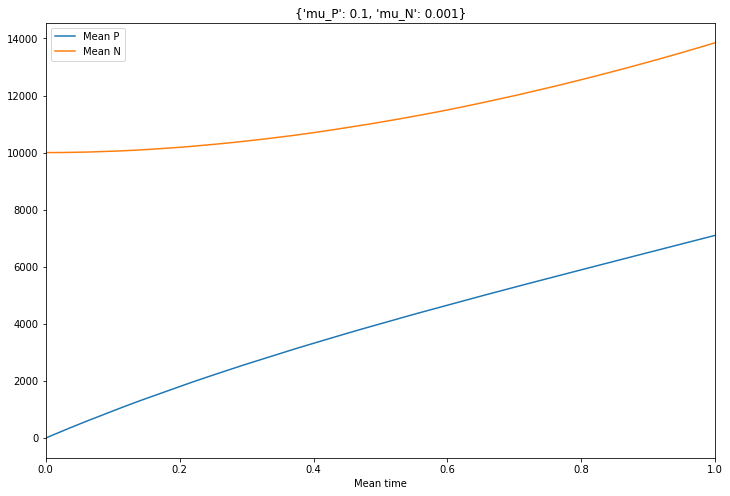

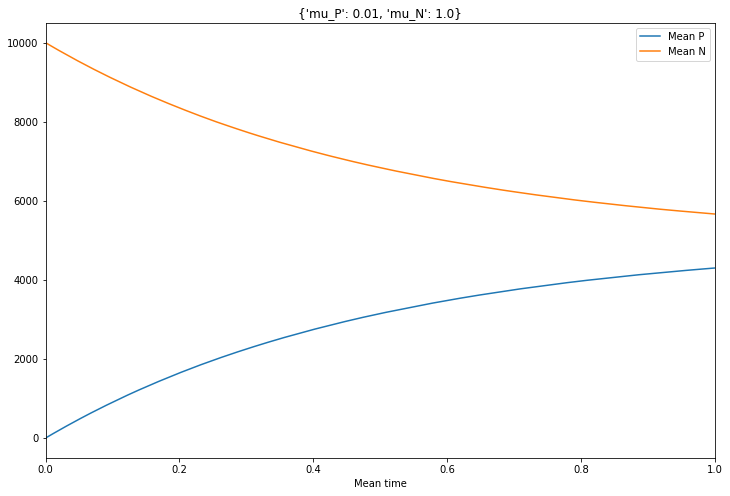

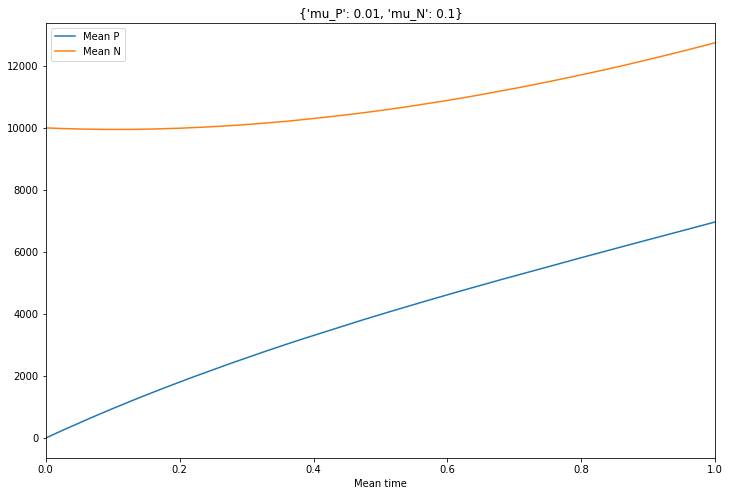

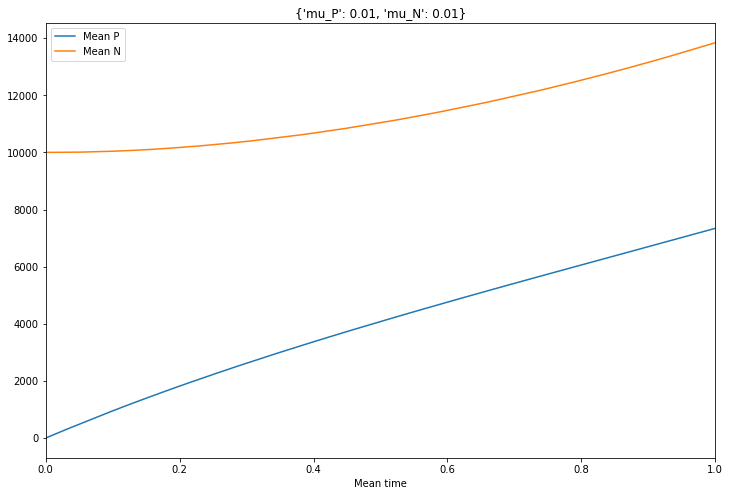

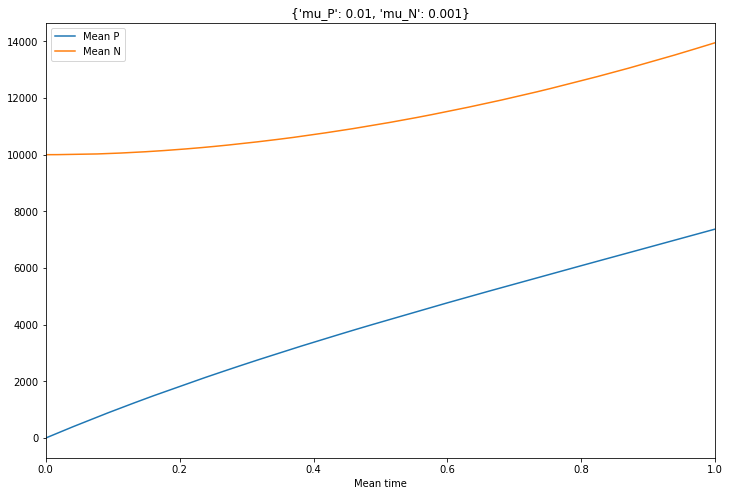

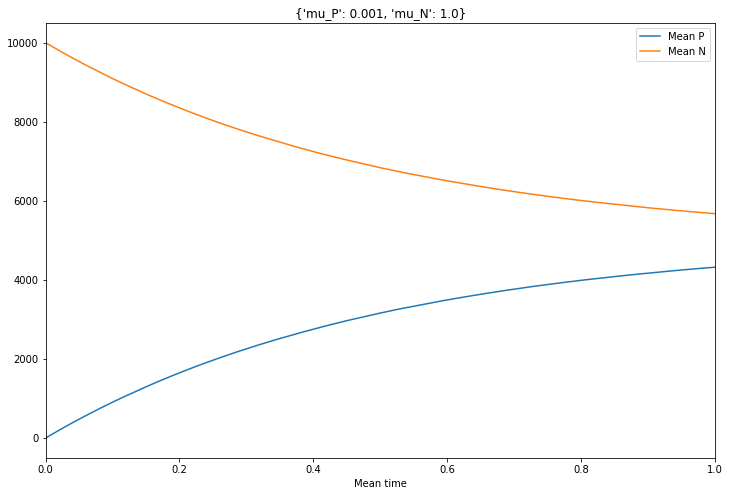

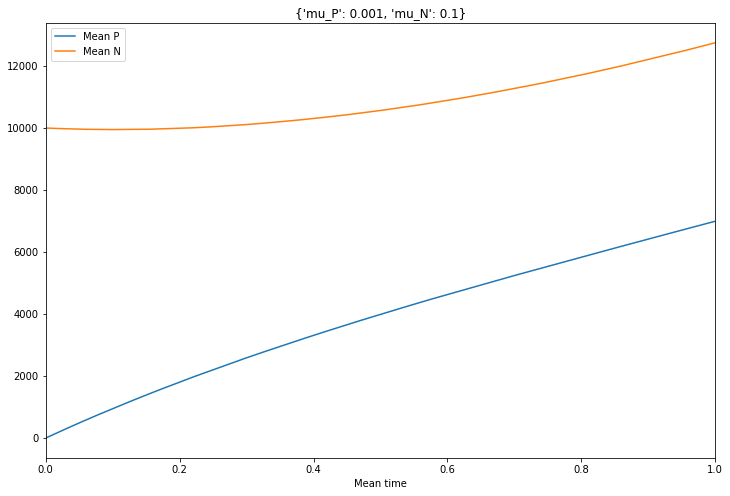

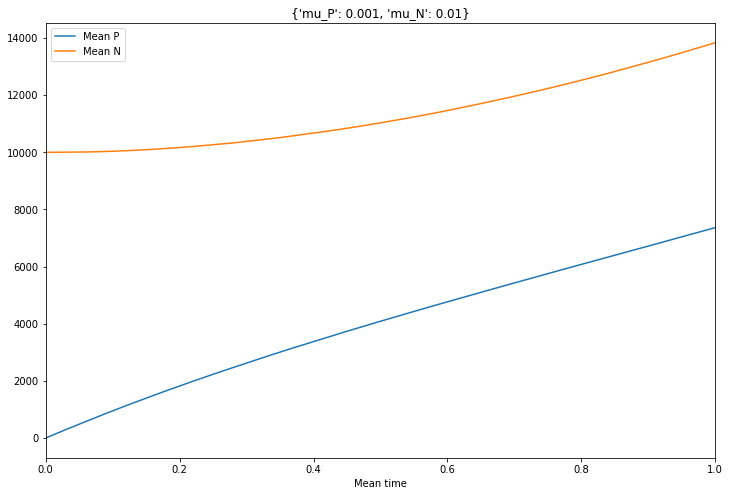

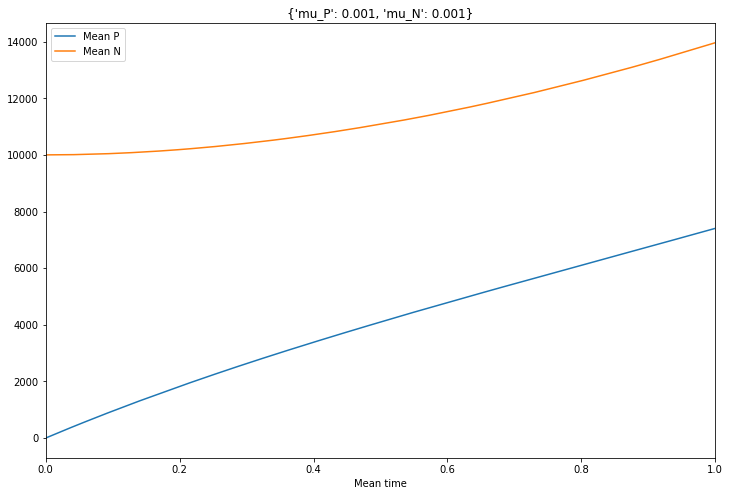

In [11]:
mean_scan = pscans[0]
for i, location in pspace.iterrows():
    targets, data = mean_scan.loc[i]
    ax = pd.DataFrame(OrderedDict(zip(targets, data))).plot(x='Mean time', kind='line', figsize=(12, 8))
    ax.set_title(dict(location))

# Bonus: Scaling To Multiple Machines Using MPI

In [12]:
pspace, pscans = mpi_simulate(system, processing=processing, batchsize=batchsize, axes=axes)

started worker 6 / -1:   0%|          | 0/16 [00:01<?, ?it/s]

setting up workers
Compiling ./gillespie_2.pyx because it changed.
[1/1] Cythonizing ./gillespie_2.pyx
running clean
removing 'build/temp.linux-x86_64-3.7' (and everything under it)
removing 'build'
running build_ext
building 'gillespie_2' extension
creating build/temp.linux-x86_64-3.7
gcc -pthread -B /home/cogle/dev/anaconda3/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/cogle/dev/anaconda3/lib/python3.7/site-packages/numpy/core/include -I/home/cogle/dev/anaconda3/include/python3.7m -c ./gillespie_2.c -o build/temp.linux-x86_64-3.7/./gillespie_2.o


worker 5 / -1 setup up:   0%|          | 0/16 [00:06<?, ?it/s]

gcc -pthread -shared -B /home/cogle/dev/anaconda3/compiler_compat -L/home/cogle/dev/anaconda3/lib -Wl,-rpath=/home/cogle/dev/anaconda3/lib -Wl,--no-as-needed -Wl,--sysroot=/ build/temp.linux-x86_64-3.7/./gillespie_2.o -o /home/cogle/dev/gillespie_modular/.simulators/gillespie_2.cpython-37m-x86_64-linux-gnu.so
set up workers


worker 7 / -1 ran location:  94%|█████████▍| 15/16 [00:56<00:07,  7.87s/it]

saving output data...
saved output data
end dispatch 0 ./.simulators/run.json
worker 4 halt
worker 1 halt
worker 2 halt
worker 3 halt
worker 6 halt
worker 5 halt
worker 7 halt


worker 7 / -1 ran location: 100%|██████████| 16/16 [00:56<00:00,  3.53s/it]

loading output data...
loaded output data
